## Generating images using Stable Diffusion (Inpainting/Outpainting)

another alternative to modify images is by using "inpainting". Inpainting refers to the process of replacing a portion of an image with another image based on a textual prompt. By providing a mask image that outlines the portion to be replaced, a textual prompt, and an image, the Stable Diffusion model can produce a new image that replaces the masked area with the object, subject, or environment described in the textual prompt.

You can use the mask provided in the data/mask.png file.

**Note:** The mask image is required to be the same resolution and aspect ratio as the image being inpainted upon.

In [6]:
# Python Built-Ins:
import base64
import io
import json
import os
import sys

# External Dependencies:
import boto3
from PIL import Image
from IPython.display import display


bedrock_runtime = boto3.client(service_name="bedrock-runtime")

Generate a Image using SDXL

In [3]:
prompt = "a beautiful mountain landscape"
negative_prompts = [
    "poorly rendered",
    "poor background details",
    "poorly drawn mountains",
    "disfigured mountain features",
]
style_preset = "photographic"  # (e.g. photographic, digital-art, cinematic, ...)
clip_guidance_preset = "FAST_GREEN" # (e.g. FAST_BLUE FAST_GREEN NONE SIMPLE SLOW SLOWER SLOWEST)
sampler = "K_DPMPP_2S_ANCESTRAL" # (e.g. DDIM, DDPM, K_DPMPP_SDE, K_DPMPP_2M, K_DPMPP_2S_ANCESTRAL, K_DPM_2, K_DPM_2_ANCESTRAL, K_EULER, K_EULER_ANCESTRAL, K_HEUN, K_LMS)
width = 768

In [5]:
request = json.dumps({
    "text_prompts": (
        [{"text": prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 5,
    "seed": 452345,
    "steps": 60,
    "style_preset": style_preset,
    "clip_guidance_preset": clip_guidance_preset,
    "sampler": sampler,
    "width": width,
})
modelId = "stability.stable-diffusion-xl"

response = bedrock_runtime.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
base_64_img_str = response_body["artifacts"][0].get("base64")
print(f"{base_64_img_str[0:80]}...")

success
iVBORw0KGgoAAAANSUhEUgAAAwAAAAIACAIAAAC6lJxtAAAEImVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


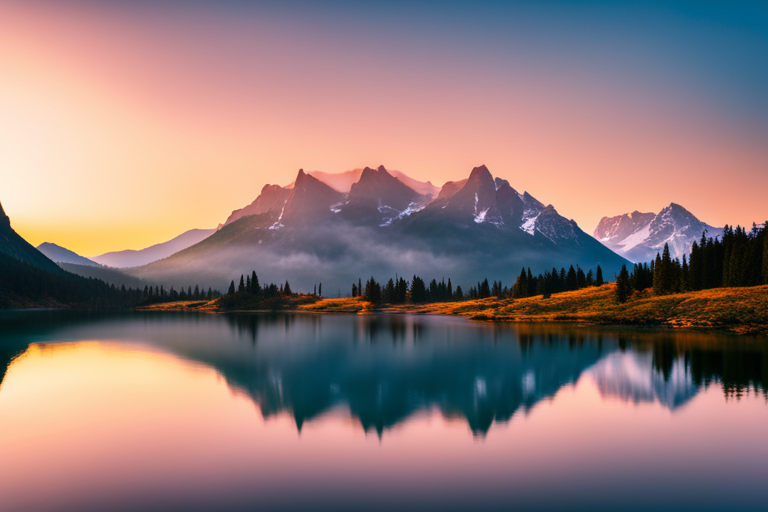

In [7]:
os.makedirs("data", exist_ok=True)
image_1 = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
image_1.save("data/image_1.png")
display(image_1)

We'll have to pass our initial image in to the API in base64 encoding, so first let's prepare that. You can use either the initial image from the previous section, or a different one if you'd prefer:

In [11]:
def image_to_base64(img) -> str:
    """Convert a PIL Image or local image file path to a base64 string for Amazon Bedrock"""
    if isinstance(img, str):
        if os.path.isfile(img):
            print(f"Reading image from file: {img}")
            with open(img, "rb") as f:
                return base64.b64encode(f.read()).decode("utf-8")
        else:
            raise FileNotFoundError(f"File {img} does not exist")
    elif isinstance(img, Image.Image):
        print("Converting PIL Image to base64 string")
        buffer = io.BytesIO()
        img.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError(f"Expected str (filename) or PIL Image. Got {type(img)}")


init_image_b64 = image_to_base64(image_1)
print(init_image_b64[:80] + "...")

Converting PIL Image to base64 string
iVBORw0KGgoAAAANSUhEUgAAAwAAAAIACAIAAAC6lJxtAAEAAElEQVR4nHy9zY41u7IcFsnVz+6Bn0QD...


In [8]:
inpaint_prompt = "add cloud"

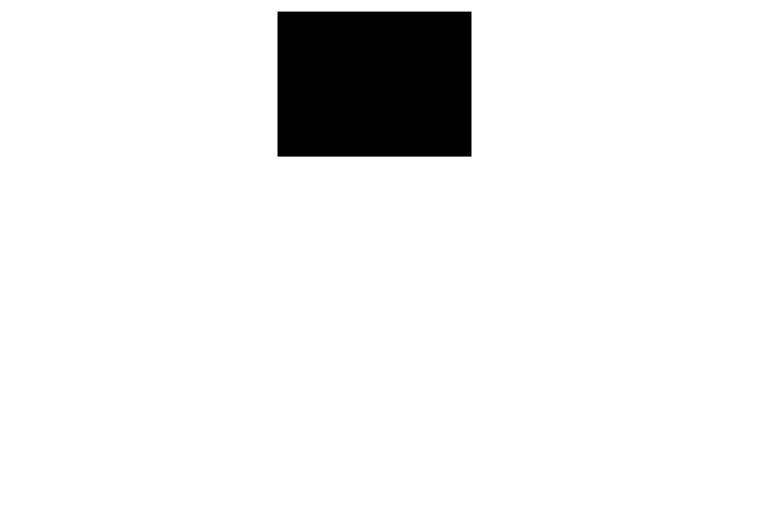

In [9]:
mask = Image.open('mask.png')
mask

In [15]:
request = json.dumps({
    "text_prompts":[{"text": inpaint_prompt}],
    "init_image": image_to_base64(image_1),
    "mask_source": "MASK_IMAGE_BLACK",
    "mask_image": image_to_base64(mask),
    "cfg_scale": 10,
    "seed": 321,
    "style_preset": style_preset,
})
modelId = "stability.stable-diffusion-xl"

response = bedrock_runtime.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
image_2_b64_str = response_body["artifacts"][0].get("base64")
print(f"{image_2_b64_str[0:80]}...")

Converting PIL Image to base64 string
Converting PIL Image to base64 string
success
iVBORw0KGgoAAAANSUhEUgAAAwAAAAIACAIAAAC6lJxtAAD/zmVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


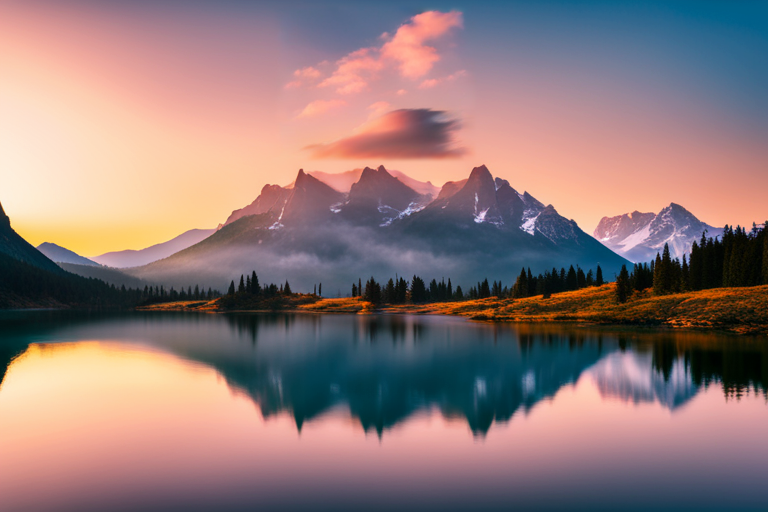

In [16]:
os.makedirs("data", exist_ok=True)
inpaint = Image.open(io.BytesIO(base64.decodebytes(bytes(image_2_b64_str, "utf-8"))))
inpaint.save("data/inpaint.png")
display(inpaint)

### > Outpainting

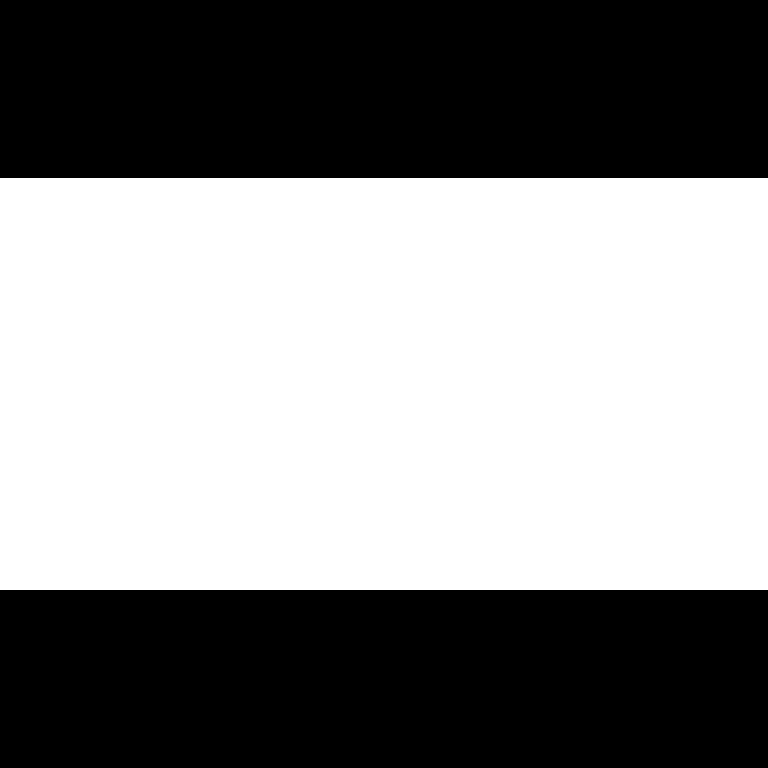

In [45]:
width, height = inpaint.size

# Calculate new dimensions with 20% padding on each side
new_width = width
new_height = 768

# Extend canvas 
new_img = Image.new('RGB', (new_width, new_height))
new_img.paste(inpaint, ((new_width - width) // 2, (new_height - height) // 2))

# Create mask
mask = Image.new('L', (new_width, new_height))
mask_img = Image.new('L', (width, height-100), 255)
mask.paste(mask_img, ((new_width - width) // 2, (new_height - height+100) // 2))

mask

In [46]:
outpaint_prompt = "add airplain in the sky"

In [47]:
request = json.dumps({
    "text_prompts":[{"text": outpaint_prompt}],
    "init_image": image_to_base64(new_img),
    "mask_source": "MASK_IMAGE_BLACK",
    "mask_image": image_to_base64(mask),
    "cfg_scale": 10,
    "seed": 321,
    "style_preset": style_preset,
})
modelId = "stability.stable-diffusion-xl"

response = bedrock_runtime.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
image_2_b64_str = response_body["artifacts"][0].get("base64")
print(f"{image_2_b64_str[0:80]}...")

Converting PIL Image to base64 string
Converting PIL Image to base64 string


ValidationException: An error occurred (ValidationException) when calling the InvokeModel operation: generation_error
sagemaker_inference.errors.BaseInferenceToolkitError: (400, 'generation_error', 'No available resolution is available for the input')
